**Installing Necessary Libraries**

In [1]:
!pip install sentence-transformers scikit-learn pandas numpy

**Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

Implementing Basic Text Normalization : Creating the preprocessing function

In [11]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # lowercase
    text = text.lower()

    # removing special characters and punctuation (keep letters, numbers, spaces)
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # removing extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [12]:
df = pd.read_csv("fake_news_dataset.csv")

# Filling null values
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

**Mapping Labels**

In [13]:
# Remove leading/trailing spaces and convert to lowercase
df['label'] = df['label'].str.strip().str.lower()

# Map to integers
df['label'] = df['label'].map({'real': 0, 'fake': 1})

# Drop rows that didn’t match 'real' or 'fake'
df = df[df['label'].notnull()]

# Convert to int
df['label'] = df['label'].astype(int)

# Safety check
assert df['label'].isnull().sum() == 0
print("Rows left after label processing:", len(df))


Rows left after label processing: 12799


In [14]:
df['content'] = df['title'] + " " + df['text']

In [15]:
df["content"] = df["content"].apply(clean_text)

**Loading Model for text processing**

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

X = model.encode(
    df['content'].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

Batches:   0%|          | 0/324 [00:00<?, ?it/s]

**Setting y**

In [ ]:
y = df['label'].values

**Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Using Logistic Regression for classification**

In [ ]:
clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

**Evaluation**

In [ ]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.513265798359865
F1 Score: 0.5156024963994239

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.52      0.51      1020
           1       0.52      0.51      0.52      1053

    accuracy                           0.51      2073
   macro avg       0.51      0.51      0.51      2073
weighted avg       0.51      0.51      0.51      2073



Adjusting Classification Threshold and Visualizing Precision-Recall

In [ ]:
# Get probabilities for the positive class ("Fake")
probs = clf.predict_proba(X_test)[:, 1]


In [ ]:
def predict_with_threshold(probs, threshold=0.5):
    """
    Convert predicted probabilities into class labels based on a custom threshold.

    Args:
        probs (array-like): Probabilities of the positive class
        threshold (float): Threshold for labeling as positive

    Returns:
        numpy array of 0/1 predictions
    """
    return (probs > threshold).astype(int)


In [ ]:
# Predict with a stricter threshold
y_pred_custom = predict_with_threshold(probs, threshold=0.8)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Example for threshold=0.8
threshold = 0.8
y_pred_custom = predict_with_threshold(probs, threshold)

print(f"Metrics at threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom))
print("Recall:", recall_score(y_test, y_pred_custom))
print("F1-Score:", f1_score(y_test, y_pred_custom))


Metrics at threshold 0.8:
Accuracy: 0.492040520984081
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


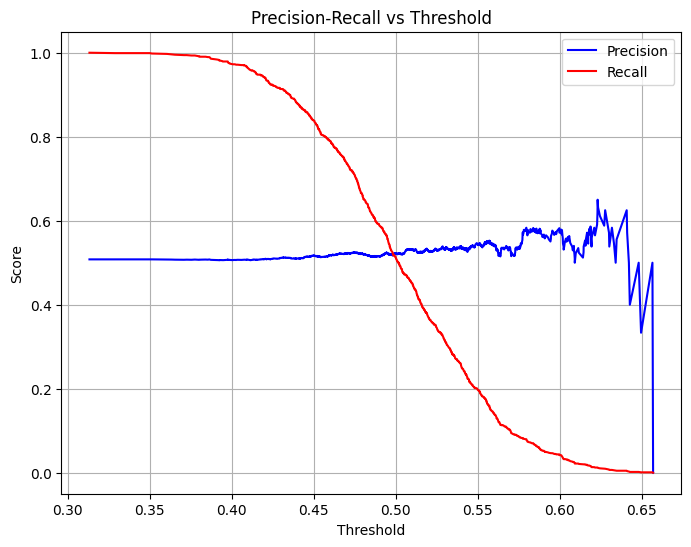

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


The Precision-Recall vs Threshold curve shows how the model's precision (blue line) and recall (red line) change as we vary the threshold for labeling a news article as "Fake."  

- **Precision**: The proportion of articles labeled "Fake" that are actually fake.  
- **Recall**: The proportion of actual fake articles that are correctly identified.  

By adjusting the threshold, we can make the model more **conservative** (high threshold → fewer false positives) or more **sensitive** (low threshold → fewer false negatives).  

For example, setting the threshold to 0.8 increases precision but may reduce recall, meaning the model labels fewer articles as "Fake," but those it does label are more likely to be truly fake.


Multi-Model Comparison Table

In [ ]:
# Dictionary to store model evaluation metrics
# Anyone who runs a model should add its metrics here.
# Format:
# model_metrics['Model Name'] = {
#     "Accuracy": ...,
#     "Precision": ...,
#     "Recall": ...,
#     "F1-Score": ...
# }

model_metrics = {}

model_metrics['Logistic Regression'] = {
    "Accuracy": 0.513265798359865,
    "Precision": 0.51,  # Weighted average from classification report
    "Recall": 0.51,     # Weighted average from classification report
    "F1-Score": 0.5156024963994239
}

print(model_metrics)

{'Logistic Regression': {'Accuracy': 0.513265798359865, 'Precision': 0.51, 'Recall': 0.51, 'F1-Score': 0.5156024963994239}}


In [ ]:
#Summary Table

metrics_df = pd.DataFrame(model_metrics).T.reset_index().rename(columns={"index": "Model Name"})
print(metrics_df)

            Model Name  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression  0.513266       0.51    0.51  0.515602


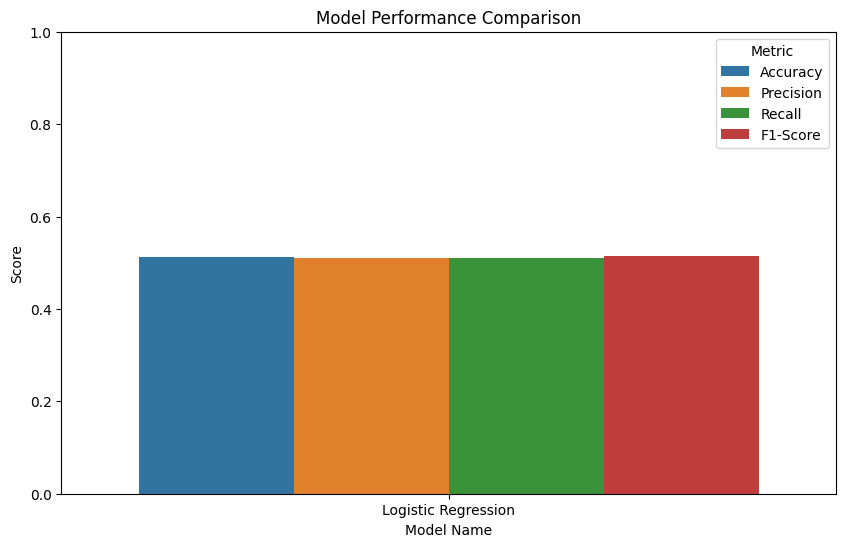

In [ ]:
plt.figure(figsize=(10,6))
metrics_plot = metrics_df.melt(id_vars='Model Name', var_name='Metric', value_name='Score')
sns.barplot(data=metrics_plot, x='Model Name', y='Score', hue='Metric')
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.show()